# Part 2.1 - Feature Engineering for RNN Model

The first thing we can do is pin our GPU-based computations to a specific GPU. The `GPU_id` can be changed in order to use a different GPU. The Azure instance in this tutorial uses 2x P40 GPUs, so you should be able to set `GPU_id` to `0` or `1`

In [1]:
import os
GPU_id = 0
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_id)

In [2]:
import warnings
warnings.filterwarnings("ignore")
import math
import cudf as gd
import pandas as pd
import numpy as np
from numba import cuda
import time
import matplotlib.pyplot as plt

from utils import scatter
%matplotlib inline

print(gd.__version__)

0.9.0a+1267.gd69c846.dirty


In [3]:
PATH = '/home/cjnolet/workspace/notebooks-extended/competition_notebooks/kaggle/plasticc/data'

In [4]:
GPU_MEMORY = 16 # GB.

In [5]:
TEST_ROWS = 453653104 # number of rows in test data
# no skip if your gpu has 32 GB memory
# otherwise, skip rows porportionally
OVERHEAD = 1.2 # cudf 0.7 introduces 20% memory overhead comparing to cudf 0.4
SKIP_ROWS = int((1 - GPU_MEMORY/(32.0*OVERHEAD))*TEST_ROWS) 

### Read data

The first thing we do for our feature engineering is load our training set CSV in to a Dataframe

In [6]:
ts_cols = ['object_id', 'mjd', 'passband', 'flux', 'flux_err', 'detected']
ts_dtypes = ['int32', 'float32', 'int32', 'float32','float32','int32']

train_gd = gd.read_csv('%s/training_set.csv'%PATH,
            names=ts_cols,dtype=ts_dtypes,skiprows=1)
test_gd = gd.read_csv('%s/test_set.csv'%PATH,
            names=ts_cols,dtype=ts_dtypes,skiprows=1+SKIP_ROWS) # skip the header

train_gd.drop_column('detected')
test_gd.drop_column('detected')

In [7]:
train_gd.head().to_pandas()

,object_id,mjd,passband,flux,flux_err
0,615,59750.421875,2,-544.810303,3.622952
1,615,59750.429688,1,-816.434387,5.553370
2,615,59750.437500,3,-471.385498,3.801213
3,615,59750.441406,4,-388.984955,11.395031
4,615,59752.406250,2,-681.858826,4.041203


### Normalization

Let's histogram the `flux` and `flux_err` values to get a feel for their distributions.

Text(0.5, 1.0, 'Original data')

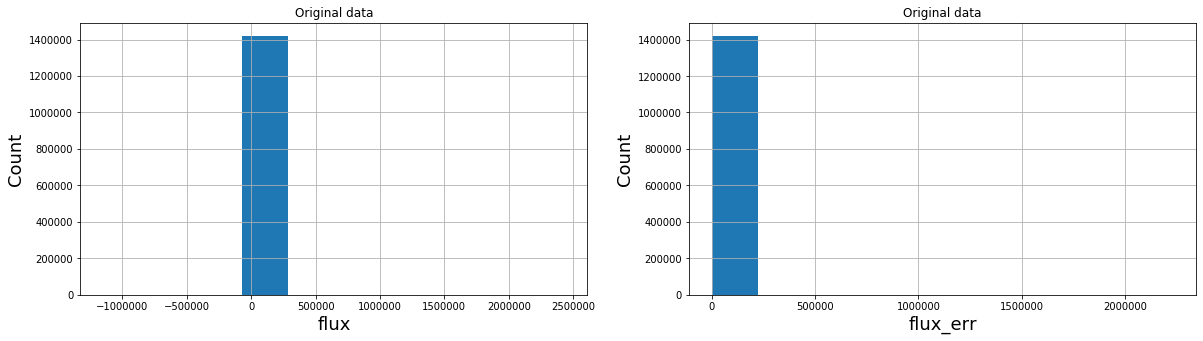

In [8]:
fig, axs = plt.subplots(1,2, figsize=(20, 5))
ax = train_gd.flux.to_pandas().hist(ax=axs[0])

ax.set_xlabel('flux', fontsize=18)
ax.set_ylabel('Count', fontsize=18)
ax.set_title('Original data')

ax = train_gd.flux_err.to_pandas().hist(ax=axs[1])

ax.set_xlabel('flux_err', fontsize=18)
ax.set_ylabel('Count', fontsize=18)
ax.set_title('Original data')

As can be seen from the charts above, most of the values occur in the bin closest to zero. This bin also eclipses the bins with smaller numbers of values. A log transform should help us normalize the values so we can better analyze the distribution.

A couple more details worth noting here:
- There are extreme negative values in `flux`, which cannot be log-transformed. These will need to be clipped
- The `flux_err` is all non-negative so we can apply log-transform directly

In [9]:
def delta_in_group(val,val_delta, default):
    for i in range(cuda.threadIdx.x, len(val), cuda.blockDim.x):
        if i>0:
            val_delta[i] = val[i]-val[i-1]
        else:
            val_delta[i] = default

def compute_delta(df):
    for col,d in zip(['flux','mjd'],[0,180]):
        df = rename_col(df,col,'val')
        df = df.groupby('object_id',method="cudf",
                        as_index=False).apply_grouped(delta_in_group,
                                  incols=['val'],
                                  outcols={'val_delta': np.float32},
                                  kwargs={'default':d},
                                  tpb=32)
        df = rename_col(df,'val',col)
        df = rename_col(df,'val_delta','%s_delta'%col)

    return df


def clip_and_log_transform(df):
    df['flux'] = df['flux'].applymap(lambda x: math.log1p(x+10) if x>-10 else 0)
    df['flux_err'] = df['flux_err'].applymap(lambda x: math.log1p(x))
    return df
            
def rename_col(df,old_col,new_col):
    """
    Rename a specific column and keep all others the same.
    """
    cols = [new_col if i==old_col else i for i in df.columns]
    df.columns = cols
    return df

def segment(df):
    df['is_boundary'] = df['mjd_delta']>90
    df['is_boundary'] = df['is_boundary'].astype('int32')
    df = df.sort_values(['object_id','mjd'])
    df['seq_id'] = df['is_boundary'].cumsum()
    return df

def reset_boundary(df):
    df['flux_delta'] = df['flux_delta']*(1-df['is_boundary'])
    #df['mjd_delta'] = df['mjd_delta']*(1-df['is_boundary'])
    df.drop_column('is_boundary')
    return df

def get_order_in_group(row_id,step):
    for i in range(cuda.threadIdx.x, len(row_id), cuda.blockDim.x):
        step[i] = i

def add_step(df):
    df['row_id'] = np.arange(df.shape[0])
    df = df.groupby('object_id',method="cudf").apply_grouped(get_order_in_group,incols=['row_id'],
                                  outcols={'step': np.int32},
                                  tpb=32)
    df = df.sort_values('row_id')
    return df

In [10]:
train_gd = clip_and_log_transform(train_gd)
test_gd = clip_and_log_transform(test_gd)

Text(0.5, 1.0, 'After log transformation')

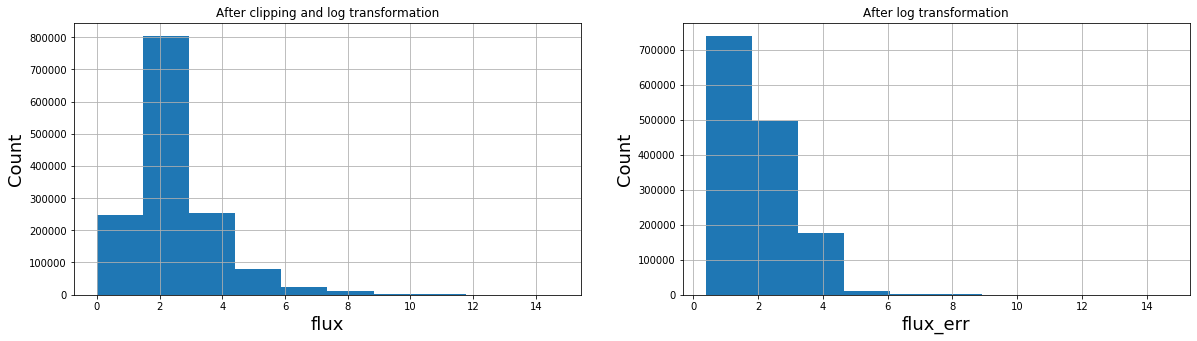

In [11]:
fig, axs = plt.subplots(1,2, figsize=(20, 5))
ax = train_gd.flux.to_pandas().hist(ax=axs[0])
ax.set_xlabel('flux', fontsize=18)
ax.set_ylabel('Count', fontsize=18)
ax.set_title('After clipping and log transformation')

ax = train_gd.flux_err.to_pandas().hist(ax=axs[1])
ax.set_xlabel('flux_err', fontsize=18)
ax.set_ylabel('Count', fontsize=18)
ax.set_title('After log transformation')

### Differentiation and Segmentation

First let's look at one light curve.

<a id="lightcurve"></a>
Original light curve.

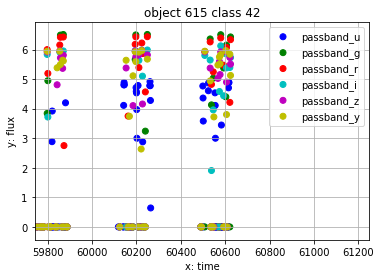

In [12]:
oid = 615
sample = train_gd[train_gd['object_id']==oid].to_pandas()
scatter(sample['mjd'].values,
        sample['flux'].values,
        values=sample['passband'].values,
        xlabel='time',ylabel='flux',title='object %d class 42'%oid)

We make the following observations:
- There are gaps in the curve along the time axis. This light curve can be spit to three separate sequences.
- The absolute value of timestamp `mjd` is not useful. 

Instead, we want to learn how `flux` varies over timestamp `mjd`, namely $\frac{\nabla flux}{\nabla mjd}$

In [13]:
train_gd = train_gd.sort_values(['object_id','mjd'])
test_gd = test_gd.sort_values(['object_id','mjd'])

In [14]:
train_gd = compute_delta(train_gd)
test_gd = compute_delta(test_gd)

In [15]:
train_gd = segment(train_gd)
test_gd = segment(test_gd)

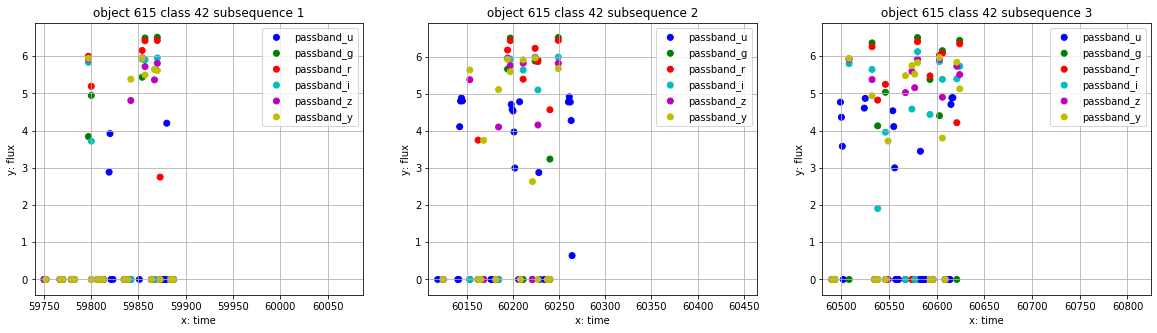

In [16]:
oid = 615
sample = train_gd[train_gd['object_id']==oid].to_pandas()
plt.figure(figsize=(20,5))
plt.subplot(131)
for i in range(1,4):
    plt.subplot(1,3,i)
    mask = sample.seq_id==i
    scatter(sample.loc[mask,'mjd'].values,
                sample.loc[mask,'flux'].values,
                values=sample.loc[mask,'passband'].values,
                xlim=(sample.loc[mask,'mjd'].min()-10,sample.loc[mask,'mjd'].max()+200),
                xlabel='time',ylabel='flux',title='object %d class 42 subsequence %d'%(oid,i))

In [17]:
train_gd.drop_column('mjd')
test_gd.drop_column('mjd')

train_gd.drop_column('flux')
test_gd.drop_column('flux')

In [18]:
train_gd.head().to_pandas()

,object_id,passband,flux_err,flux_delta,mjd_delta,is_boundary,seq_id
0,615,2,1.531034,0.0,180.000000,1,1
1,615,1,1.879979,0.0,0.007812,0,1
2,615,3,1.568869,0.0,0.007812,0,1
3,615,4,2.517296,0.0,0.003906,0,1
4,615,2,1.617645,0.0,1.964844,0,1


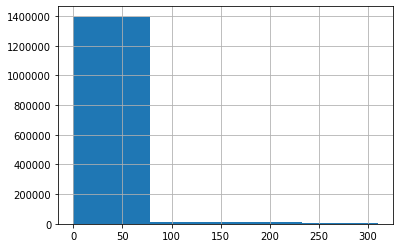

In [19]:
train_gd["mjd_delta"].to_pandas().hist(bins=4)

We can see that most deltas are < 90, so we should be able to threshold at 90 to determine gaps. 

Timeseries sequences can be numbered by marking a boolean `1` when a boundary condition occurs:
- The first time delta in the sequence will be zero, since it has no prior time to difference
- Any time delta gaps > 90 will signal a new timeseries sequence

Since the sequences have been ordered by id and time, they can be numbered in a monotonically increasing order using `cumsum()` 

Comparing to the [original light curve](#lightcurve), we can visually verfiy the curve is segmented correctly.

### Reset the values of `flux_delta` and `mjd_delta` at the boundary of subsequence

In [20]:
boundary_thres = 90

train_gd = reset_boundary(train_gd)
test_gd = reset_boundary(test_gd)

### Lastly, we scale `mjd_delta`

Text(0.5, 1.0, 'Original')

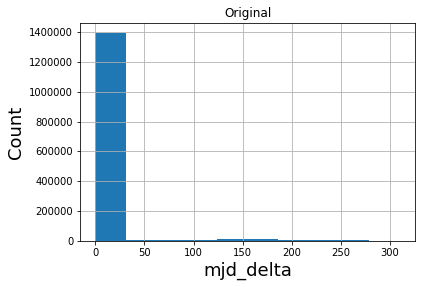

In [21]:
fig, axs = plt.subplots(1,1)
ax = train_gd.mjd_delta.to_pandas().hist()
ax.set_xlabel('mjd_delta', fontsize=18)
ax.set_ylabel('Count', fontsize=18)
ax.set_title('Original')

In [22]:
train_gd['mjd_delta'] /= boundary_thres # scale mjd_delta
test_gd['mjd_delta'] /= boundary_thres

Text(0.5, 1.0, 'After scaling')

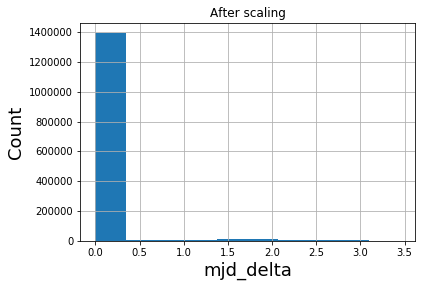

In [23]:
ax = train_gd.mjd_delta.to_pandas().hist()
ax.set_xlabel('mjd_delta', fontsize=18)
ax.set_ylabel('Count', fontsize=18)
ax.set_title('After scaling')

In [24]:
for col in train_gd.columns:
    print(col,train_gd[col].min(),train_gd[col].max())

object_id 615 130779836
passband 0 5
flux_err 0.3810037076473236 14.619336128234863
flux_delta -14.704561233520508 14.704561233520508
mjd_delta 0.0 3.4457030296325684
seq_id 1 26220


In [25]:
train_pd = train_gd.to_pandas()
test_pd = test_gd.to_pandas()

### Create step number for each light curve sequence

Step numbers are needed for each light curve to fcailitate sampling.

In [26]:
cols = [col for col in train_gd.columns]
for col in cols:
    if col!='object_id':
        train_gd.drop_column(col)
        test_gd.drop_column(col)

In [27]:
train_gd = add_step(train_gd)
test_gd = add_step(test_gd)

In [35]:
train_pd['step'] = train_gd['step'].to_pandas().values
test_pd['step'] = test_gd['step'].to_pandas().values

In [36]:
train_pd.head()

,object_id,passband,flux_err,flux_delta,mjd_delta,seq_id,step
0,615,2,1.531034,0.0,2.000000,1,0
1,615,1,1.879979,0.0,0.000087,1,1
2,615,3,1.568869,0.0,0.000087,1,2
3,615,4,2.517296,0.0,0.000043,1,3
4,615,2,1.617645,0.0,0.021832,1,4


In [37]:
train_pd.to_pickle('train_rnn.pkl')
test_pd.to_pickle('test_rnn.pkl')

### Conclusion

In this notebook we process the light curve data in order to train a RNN. 
- `object_id` and `seq_id` can be used to sample sequences from the dataframe.
- `mjd_delta` and `flux_delta` enable RNN to learn the temporal pattern of light curves.
- `passband` is an original feature and will be embedded.